In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from torchvision.datasets import CIFAR10
from torchvision.transforms import Normalize, Resize, Compose, CenterCrop, InterpolationMode
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from astra.torch.models import EfficientNet, CNN, AstraModel, Backbone, Module, LearningToLoss
import torch.nn.functional as F
from astra.torch.al import RandomAcquisition, RandomStrategy
from astra.torch.utils import train_fn

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

device = "cpu"


In [2]:
eff_transform = EfficientNet_B0_Weights.DEFAULT.transforms()

## Prepare the dataset

In [3]:
train_data = CIFAR10(root="./data", train=True, download=True)
test_data = CIFAR10(root="./data", train=False, download=True)

train_inputs = torch.tensor(train_data.data).permute(0, 3, 1, 2).float() / 255
train_outputs = torch.tensor(train_data.targets).long()

test_inputs = torch.tensor(test_data.data).permute(0, 3, 1, 2).float() / 255
test_outputs = torch.tensor(test_data.targets).long()

print(train_inputs.shape, train_inputs.type)
print(train_outputs.shape, train_outputs.type)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32]) <built-in method type of Tensor object at 0x146b6ee10>
torch.Size([50000]) <built-in method type of Tensor object at 0x146b6c050>


## Divide into train, test and pool

In [4]:
train_size = 100

idx = torch.randperm(len(train_inputs))
train_indices = idx[:train_size]
pool_indices = idx[train_size:]
test_indices = torch.arange(len(test_inputs))
print(len(train_indices), len(pool_indices), len(test_indices))

100 49900 10000


## Test the baselines

### Fitted on initial train

In [5]:
class BasicBlock(AstraModel):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(AstraModel):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.initial = self.init_layer()
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.final = self.final_layer(num_classes=num_classes)

    def final_layer(self, num_classes=10):
        layers = []
        layers.append(nn.AvgPool2d(4))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(512*BasicBlock.expansion, num_classes))
        return nn.Sequential(*layers)

    def init_layer(self):
        layers = []
        layers.append(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

In [6]:
class LossNet(AstraModel):
    def __init__(self, interim_dim=128):
        super(LossNet, self).__init__()
        self.interim_dim = interim_dim

    def forward(self, x):
        outputs = []
        for i in range(len(x)):
            feature_size = x[i].shape[2]
            num_channel = x[i].shape[1]
            out = F.avg_pool2d(x[i], feature_size)
            out = out.view(out.size(0), -1)
            out = F.relu(nn.Linear(num_channel, self.interim_dim)(out))
            outputs.append(out)
        outputs = torch.cat(outputs, 1)
        out = nn.Flatten()(nn.Linear(4 * self.interim_dim, 1)(outputs))
        return out     

In [7]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

LossNet = LossNet(128)

backbone_model = Backbone(ResNet18())
module_model = Module(LossNet)

model = LearningToLoss(backbone_model, module_model)

In [8]:
result = train_fn(
    model,
    train_inputs[train_indices].to(device),
    train_outputs[train_indices].to(device),
    loss_fn=nn.CrossEntropyLoss(reduction="none"),
    lr=1e-4,
    epochs=50,
    batch_size=32)

  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 4.020326: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s] 


Epoch 1: 18.908589172363282


Loss: 4.013383: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s] 


Epoch 2: 18.27206756591797


Loss: 3.534428: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s] 


Epoch 3: 17.880996856689453


Loss: 3.521517: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s] 


Epoch 4: 17.604866943359376


Loss: 3.487186: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s] 


Epoch 5: 17.257546920776367


Loss: 3.807532: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s] 


Epoch 6: 17.22317153930664


Loss: 3.256057: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s] 


Epoch 7: 16.667648849487303


Loss: 2.587599: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s] 


Epoch 8: 16.43767837524414


Loss: 2.797615: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s] 


Epoch 9: 16.458509979248046


Loss: 2.265902: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s] 


Epoch 10: 16.299110717773438


Loss: 2.792804: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s] 


Epoch 11: 16.397510681152344


Loss: 2.385285: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 12: 16.186076202392577


Loss: 3.348326: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s] 


Epoch 13: 16.45537826538086


Loss: 2.401247: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s] 


Epoch 14: 16.204799041748046


Loss: 2.702006: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s] 


Epoch 15: 16.22044448852539


Loss: 2.272695: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s] 


Epoch 16: 16.16439910888672


Loss: 2.310867: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s] 


Epoch 17: 16.173522186279296


Loss: 2.441916: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s] 


Epoch 18: 16.211571350097657


Loss: 2.639336: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s] 


Epoch 19: 16.311144561767577


Loss: 2.778498: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s] 


Epoch 20: 16.304564361572265


Loss: 2.221812: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 21: 16.151142120361328


Loss: 2.258999: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 22: 16.14454475402832


Loss: 3.495021: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s] 


Epoch 23: 16.5928059387207


Loss: 2.123294: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s] 


Epoch 24: 16.14385353088379


Loss: 2.311043: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 25: 16.217200241088868


Loss: 2.004650: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s] 


Epoch 26: 16.11829948425293


Loss: 2.405215: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s] 


Epoch 27: 16.142915191650392


Loss: 2.408022: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s] 


Epoch 28: 16.17020751953125


Loss: 2.549355: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 29: 16.338079376220705


Loss: 2.525365: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 30: 16.283090667724608


Loss: 2.148853: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 31: 16.09288932800293


Loss: 2.562157: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s] 


Epoch 32: 16.25076316833496


Loss: 2.458240: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s] 


Epoch 33: 16.186597747802736


Loss: 3.267851: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 34: 16.507794189453126


Loss: 2.062511: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s] 


Epoch 35: 16.104654998779296


Loss: 3.037952: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 36: 16.379767456054687


Loss: 2.559583: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s] 


Epoch 37: 16.081427459716796


Loss: 2.366161: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s] 


Epoch 38: 16.103138580322266


Loss: 2.311278: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s] 


Epoch 39: 16.181264114379882


Loss: 2.354229: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s] 


Epoch 40: 16.268292236328126


Loss: 2.383883: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s] 


Epoch 41: 16.238540115356447


Loss: 2.083612: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s] 


Epoch 42: 15.954544982910157


Loss: 2.389446: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s] 


Epoch 43: 16.247773895263673


Loss: 2.466246: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s] 


Epoch 44: 16.17975112915039


Loss: 3.023495: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s] 


Epoch 45: 16.329405975341796


Loss: 2.327254: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s] 


Epoch 46: 16.07275047302246


Loss: 2.522507: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s] 


Epoch 47: 16.227900314331055


Loss: 2.221963: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s] 


Epoch 48: 16.18601707458496


Loss: 2.330052: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s] 


Epoch 49: 15.989646072387695


Loss: 2.951918: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s] 

Epoch 50: 16.26404685974121


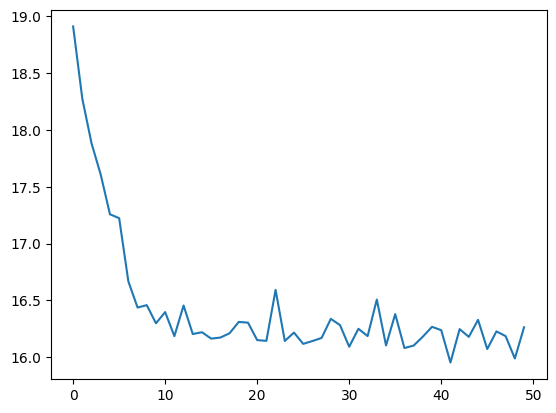

In [26]:
plt.plot(result[1])

In [9]:
# model.eval()

# for name, indices, inputs, outputs in zip(["train", "test"], [train_indices, test_indices], [train_inputs, test_inputs], [train_outputs, test_outputs]):
#     y_preds = predict_class(model, inputs[indices].to(device), batch_size=128).cpu()
#     print(f"{name} accuracy", accuracy_score(outputs[indices], y_preds))

In [10]:
# resnet = ResNet18()
# x = torch.randn(1, 3, 32, 32)

In [11]:
# num_layers = sum(1 for name, _ in resnet.named_children() if name.startswith('layer'))
# print(num_layers)

# out0 = resnet.layer0(x)
# out0 = resnet.initial(x)
# out1 = resnet.layer1(out0)
# out2 = resnet.layer2(out1)
# out3 = resnet.layer3(out2)
# out4 = resnet.layer4(out3)
# out = resnet.final(out4)
# x = [out1,out2,out3,out4]

In [12]:
# class LossNet(AstraModel):
#     def __init__(self, feature_sizes=[32, 16, 8, 4], num_channels=[64, 128, 256, 512], interm_dim=128):
#         super(LossNet, self).__init__()
        
#         self.GAP1 = nn.AvgPool2d(feature_sizes[0])
#         self.GAP2 = nn.AvgPool2d(feature_sizes[1])
#         self.GAP3 = nn.AvgPool2d(feature_sizes[2])
#         self.GAP4 = nn.AvgPool2d(feature_sizes[3])

#         self.FC1 = nn.Linear(num_channels[0], interm_dim)
#         self.FC2 = nn.Linear(num_channels[1], interm_dim)
#         self.FC3 = nn.Linear(num_channels[2], interm_dim)
#         self.FC4 = nn.Linear(num_channels[3], interm_dim)

#         self.linear = nn.Linear(4 * interm_dim, 1)
    
#     def forward(self, features):
#         out1 = self.GAP1(features[0])
#         out1 = out1.view(out1.size(0), -1)
#         out1 = F.relu(self.FC1(out1))

#         out2 = self.GAP2(features[1])
#         out2 = out2.view(out2.size(0), -1)
#         out2 = F.relu(self.FC2(out2))

#         out3 = self.GAP3(features[2])
#         out3 = out3.view(out3.size(0), -1)
#         out3 = F.relu(self.FC3(out3))

#         out4 = self.GAP4(features[3])
#         out4 = out4.view(out4.size(0), -1)
#         out4 = F.relu(self.FC4(out4))

#         out = self.linear(torch.cat((out1, out2, out3, out4), 1))
#         return out

In [13]:
# model = ResNet18().to(device)

# result = train_fn(
#     model,
#     train_inputs[train_indices].to(device),
#     train_outputs[train_indices].to(device),
#     loss_fn=nn.CrossEntropyLoss(),
#     lr=1e-4,
#     epochs=50,
#     batch_size=32,)

In [14]:
# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

In [15]:
# result = train_fn(
#     model,
#     train_inputs[train_indices].to(device),
#     train_outputs[train_indices].to(device),
#     loss_fn=nn.CrossEntropyLoss(),
#     lr=1e-4,
#     n_epochs=50,
#     batch_size=32,
#     enable_tqdm=True,  # Use tqdm for progress bar
# )

In [16]:
# model = EfficientNet(
#     efficientnet_b0, EfficientNet_B0_Weights.DEFAULT, output_dim=10
# ).to(device)

# result = train_fn(
#     model,
#     train_inputs[train_indices].to(device),
#     train_outputs[train_indices].to(device),
#     loss_fn=nn.CrossEntropyLoss(),
#     lr=1e-4,
#     n_epochs=50,
#     batch_size=32,
#     enable_tqdm=True,  # Use tqdm for progress bar
# )

In [17]:
# plt.plot(result["iter_losses"])

In [18]:
# model.eval()

# for name, indices, inputs, outputs in zip(["train", "test"], [train_indices, test_indices], [train_inputs, test_inputs], [train_outputs, test_outputs]):
#     y_preds = predict_class(model, inputs[indices].to(device), batch_size=128).cpu()
#     print(f"{name} accuracy", accuracy_score(outputs[indices], y_preds))

### Fitted on train + pool

In [19]:
# model = EfficientNet(
#     efficientnet_b0, EfficientNet_B0_Weights.DEFAULT, output_dim=10
# ).to(device)
# # model = CNN(224, 5, 3, [16, 32, 64, 128, 256], [512], 10, activation=nn.ReLU(), dropout=0.0).to(device)

# result = train_fn(
#     model,
#     train_inputs.to(device),
#     train_outputs.to(device),
#     loss_fn=nn.CrossEntropyLoss(),
#     lr=1e-4,
#     n_epochs=2,
#     batch_size=32,
#     enable_tqdm=True,  # Use tqdm for progress bar
# )

In [20]:
# plt.plot(result["iter_losses"])

In [21]:
# model.eval()

# for name, indices, inputs, outputs in zip(["train", "test"], [torch.cat([train_indices, pool_indices]), test_indices], [train_inputs, test_inputs], [train_outputs, test_outputs]):
#     y_preds = predict_class(model, inputs[indices].to(device), batch_size=128).cpu()
#     print(f"{name} accuracy", accuracy_score(outputs[indices], y_preds))

## Active Learning

In [22]:
al_iterations = 10
n_query_samples = 20

inputs = train_inputs[train_indices].to(device)
outputs = train_outputs[train_indices].to(device)

model = EfficientNet(
    efficientnet_b0, EfficientNet_B0_Weights.DEFAULT, output_dim=10
).to(device)

result = train_fn(
    model,
    inputs,
    outputs,
    loss_fn=nn.CrossEntropyLoss(),
    lr=1e-4,
    n_epochs=30,
    batch_size=64,
    enable_tqdm=True,  # Use tqdm for progress bar
)

acquisition = RandomAcquisition()
strategy = RandomStrategy(acquisition, train_inputs, train_outputs)

queried_indices = torch.tensor([], dtype=torch.long)
test_accuracy = []
train_accuracy = []
train_loss = []
for iteration in range(al_iterations):
    # Query samples to be annotated
    result = strategy.query(model, pool_indices=pool_indices, batch_size=64, n_query_samples=n_query_samples)
    indices = result["RandomAcquisition"]
    
    # Update indices
    queried_indices = torch.cat([queried_indices, indices])
    pool_indices = np.setdiff1d(pool_indices.numpy(), indices.numpy())
    pool_indices = torch.from_numpy(pool_indices).long()
    
    # New inputs
    inputs = train_inputs[torch.cat([train_indices, queried_indices])].to(device)
    outputs = train_outputs[torch.cat([train_indices, queried_indices])].to(device)
    
    # Fine-tune model
    result = train_fn(
        model,
        inputs,
        outputs,
        loss_fn=nn.CrossEntropyLoss(),
        lr=1e-4,
        n_epochs=5,
        batch_size=64,
        enable_tqdm=True,  # Use tqdm for progress bar
    )
    
    train_loss.append(result["epoch_losses"][-1])
    
    # Train accuracy
    y_preds = predict_class(model, inputs, batch_size=128).cpu()
    train_accuracy.append(accuracy_score(outputs.cpu(), y_preds))
    
    # Test accuracy
    y_preds = predict_class(model, test_inputs[test_indices].to(device), batch_size=128).cpu()
    test_accuracy.append(accuracy_score(test_outputs[test_indices], y_preds))
    
    print(f"AL iteration {iteration}. {len(queried_indices)} samples queried. Test accuracy {test_accuracy[-1]}")

TypeError: EfficientNet.__init__() got an unexpected keyword argument 'output_dim'

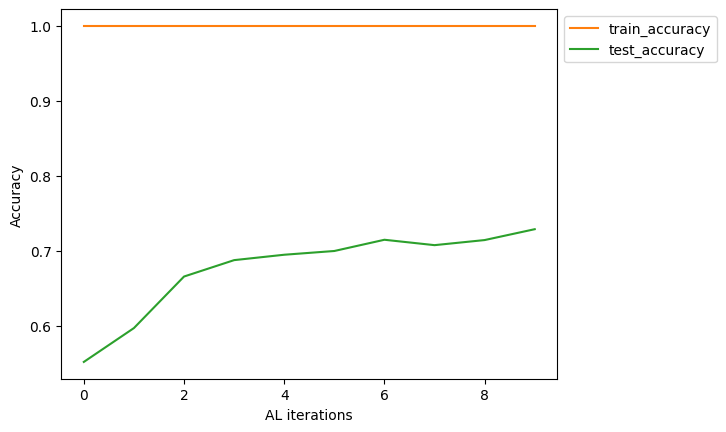

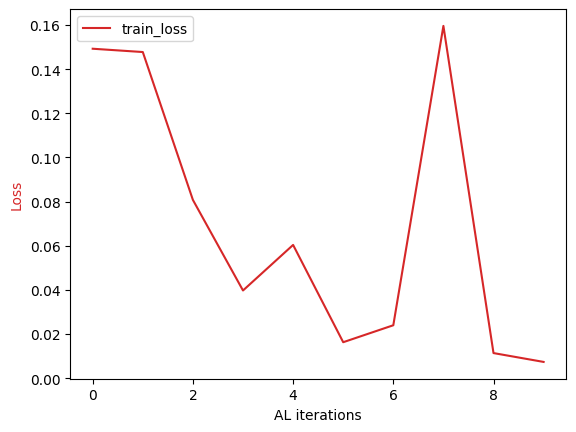

In [ ]:
plt.plot(train_accuracy, label="train_accuracy", color="C1")
plt.plot(test_accuracy, label="test_accuracy", color="C2")
plt.xlabel("AL iterations")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1, 1))

plt.figure()
plt.plot(train_loss, label="train_loss", color="C3")
plt.ylabel("Loss", color="C3")
plt.xlabel("AL iterations")
plt.legend()